In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro
import statsmodels.api as sm
import plotly.figure_factory as ff
import plotly
from scipy.stats import t

import os

In [2]:
list_df = {}
for i in os.listdir('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-ababkov/data_champ/'):
    way_to_folder = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-ababkov/data_champ/' + i
    list_df[i.replace(".csv", "")] = way_to_folder

In [3]:
dic_df = {}
for k, v in list_df.items():
    dic_df[k] = pd.read_csv(v, sep=';')

In [4]:
list_df.keys()

dict_keys(['lesson', 'chat', 'user_events', 'education_group', 'connection', 'user_info', 'education_test', 'student_test_result', 'curriculum_education_test', 'lesson_curriculum', 'meeting', 'event_types'])

## Анализ таблиц

In [5]:
# Количество запланированных уроков

planned = dic_df['lesson'].groupby('type', as_index=False).agg({'id' : 'count'})

In [6]:
dic_df['lesson'] = dic_df['lesson'].rename(columns={'id' : 'lesson_id'})

In [7]:
lessons_meet = dic_df['meeting'].merge(dic_df['lesson'], how='inner')

In [8]:
# Количество проведенных уроков

сonducted_lessons = lessons_meet.groupby('type', as_index=False).agg({'lesson_id' : 'count'})

In [9]:
lessons = planned.merge(сonducted_lessons, how='left', on='type') \
    .rename(columns={'id' : 'planned', 'lesson_id' : 'done'}) \
    .fillna(0)

lessons['done'] = lessons['done'].astype(int)

lessons.head()
lessons.to_csv('lessons.csv')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


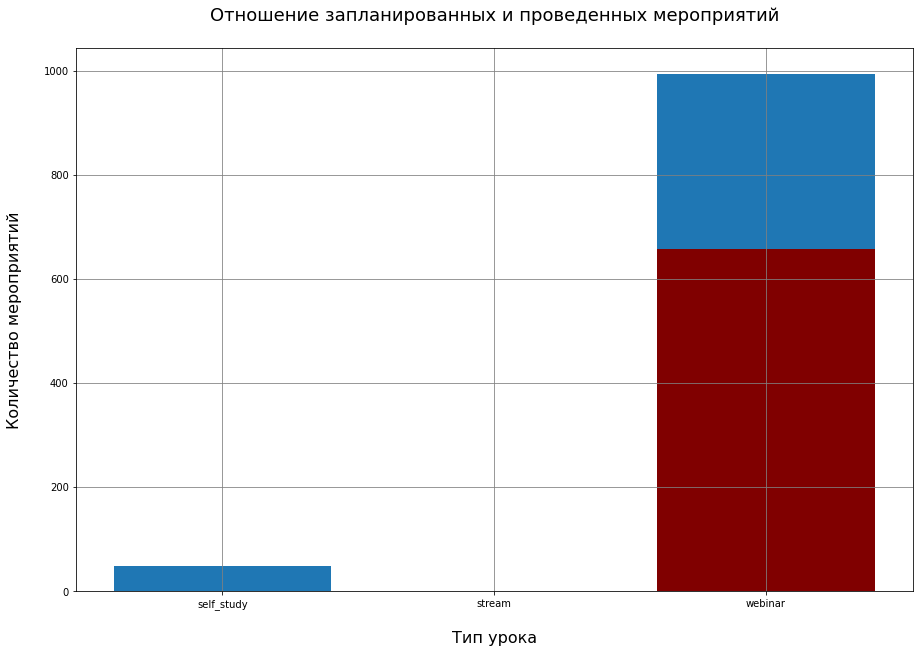

In [10]:
plt.figure(figsize=(15,10))
plt.grid(color='grey')

ax = plt.subplot()
ax.bar(lessons["type"], lessons["planned"])
ax.bar(lessons["type"], lessons["done"], color="maroon")

plt.xlabel('\nТип урока', size= 16)
plt.ylabel('Количество мероприятий\n', size= 16)
plt.title('Отношение запланированных и проведенных мероприятий\n', size= 18)
plt.savefig('planned_done_lessons.png')

## Синий цвет - запланировано, красный цвет - проведено

In [11]:
group_by_user = dic_df['user_info'].groupby('education_group_id', as_index=False) \
    .agg({'user_id' : 'count'})

In [12]:
dic_df['user_events'] = dic_df['user_events'].rename(columns={'event_type_id' : 'id'})

In [13]:
total = dic_df['user_events'].merge(dic_df['event_types'], how='inner')

In [14]:
users = total.merge(dic_df['user_info'], how='inner')

Средний процент выполнения домашек по users

In [15]:
dic_df['student_test_result'] = dic_df['student_test_result'].rename(columns={'education_test_id' : 'id'})

In [16]:
homeworks = dic_df['education_test'].merge(dic_df['student_test_result'], how='inner')

In [17]:
homeworks.head()

,id,title,type,student_id,attempts_count,spent_time,percent,result,created_at,updated_at
0,129563,Задание 1,type6,9935451,1,149.0,0,false,2021-09-30 11:07:53,2021-09-30 12:54:35
1,129563,Задание 1,type6,10266835,1,12.0,0,false,2021-10-30 07:36:44,2021-11-07 09:04:31
2,129563,Задание 1,type6,1245466,1,206.0,100,true,2021-10-22 17:56:46,2021-10-23 18:19:10
3,129563,Задание 1,type6,10207647,1,748.0,100,true,2021-10-18 11:38:22,2021-10-18 12:41:51
4,129563,Задание 1,type6,9957566,1,141.0,100,true,2021-12-29 18:11:45,2022-01-09 07:32:12


In [18]:
percent_by_user = homeworks.groupby(['student_id'], as_index=False) \
    .agg({'percent' : 'mean', 'spent_time' : 'mean'}) \
    .rename(columns={'student_id' : 'user_id', 'percent' : 'percent_mean', 'spent_time' : 'spent_time_mean'}) \
    .round(2)

Среднее количество попыток на домашку

In [19]:
st = dic_df['student_test_result'].groupby('student_id', as_index=False).attempts_count.mean()
st = st.rename(columns={'student_id':'user_id'})

In [20]:
percent_by_user = percent_by_user.merge(st, on='user_id')

% успешного выполнения д\з по каждому  виду д\з (education_test). 4 тип не учитываем.

In [21]:
per_true = homeworks.query('result == "true"') \
    .groupby('type', as_index=False) \
    .agg({'student_id' : 'count'}) \
    .rename(columns={'student_id' : 'done'})

In [22]:
total_hw = homeworks.groupby('type', as_index=False) \
    .agg({'student_id' : 'count'}) \
    .rename(columns={'student_id' : 'total'})

In [23]:
per_true['total'] = total_hw['total']

In [24]:
per_true['done_rate'] = (per_true.done / per_true.total * 100).round(2)
per_true = per_true.query('type != "type4"')

In [25]:
per_true.to_csv('per_true.csv')

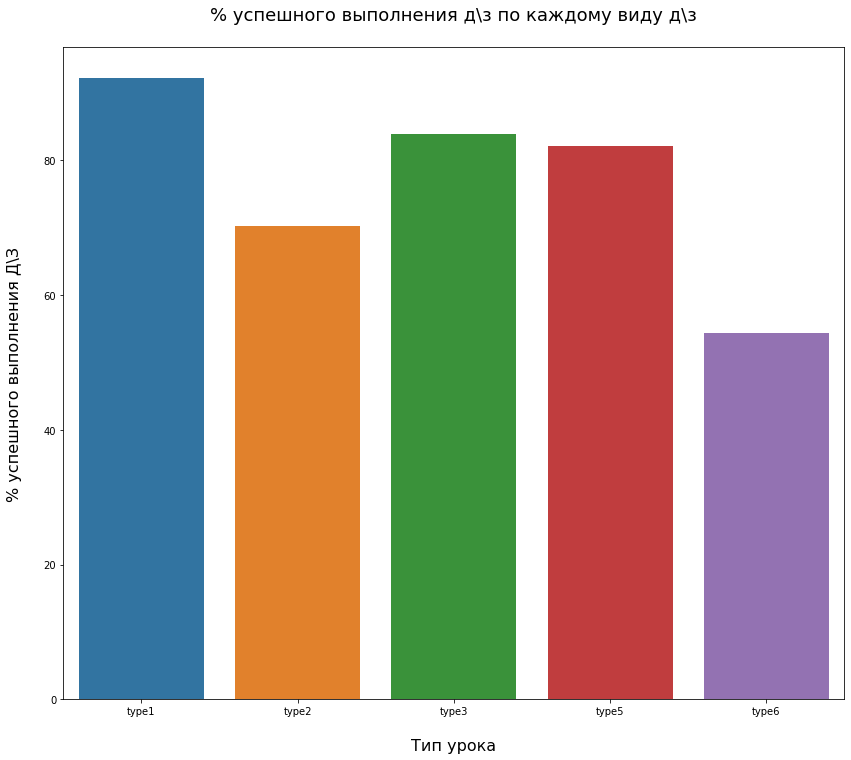

In [26]:
plt.figure(figsize=(14, 12))

ax = sns.barplot(data=per_true, x="type", y="done_rate")

plt.xlabel('\nТип урока', size= 16)
plt.ylabel('% успешного выполнения Д\З\n', size= 16)
plt.title('% успешного выполнения д\з по каждому виду д\з\n', size= 18)
plt.savefig('tests_%.png')

Девайсы учеников

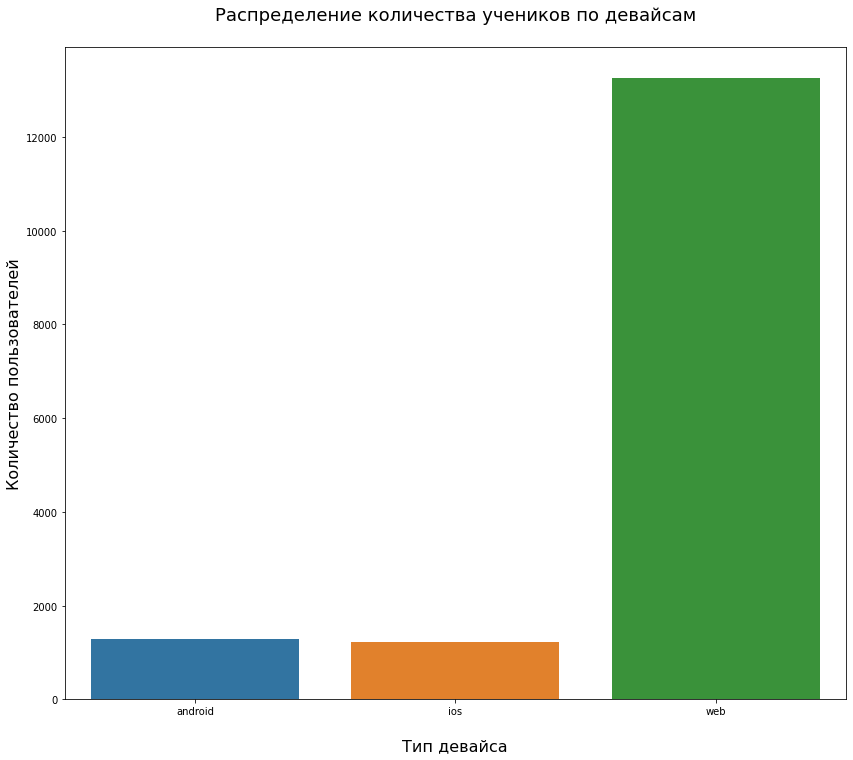

In [27]:
device_users = dic_df['connection'].query('role == "attendee"') \
    .groupby('device', as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns={'user_id' : 'size users devices'})

plt.figure(figsize=(14, 12))

sns.barplot(data=device_users, x="device", y="size users devices")

plt.xlabel('\nТип девайса', size= 16)
plt.ylabel('Количество пользователей', size= 16)
plt.title('Распределение количества учеников по девайсам\n', size= 18)
plt.savefig('device_users.png')

In [28]:
device_users.to_csv('device_users.csv')

Статистика по курсам

In [29]:
courses = dic_df['education_group'].rename(columns={'id' : 'education_group_id'})

courses = courses.merge(group_by_user)

courses = courses.rename(columns={'user_id' : 'size_group'})

courses = courses[['title', 'size_group']]

In [30]:
courses_title = ['Информатика', 'Математика_1', 'Химия', 'Физика', 'Русский язык', 'Обществознание', 'Математика_2',
                'Литература', 'История', 'Биология', 'Английский язык']

courses['title'] = courses_title

In [31]:
courses.to_csv('courses.csv')

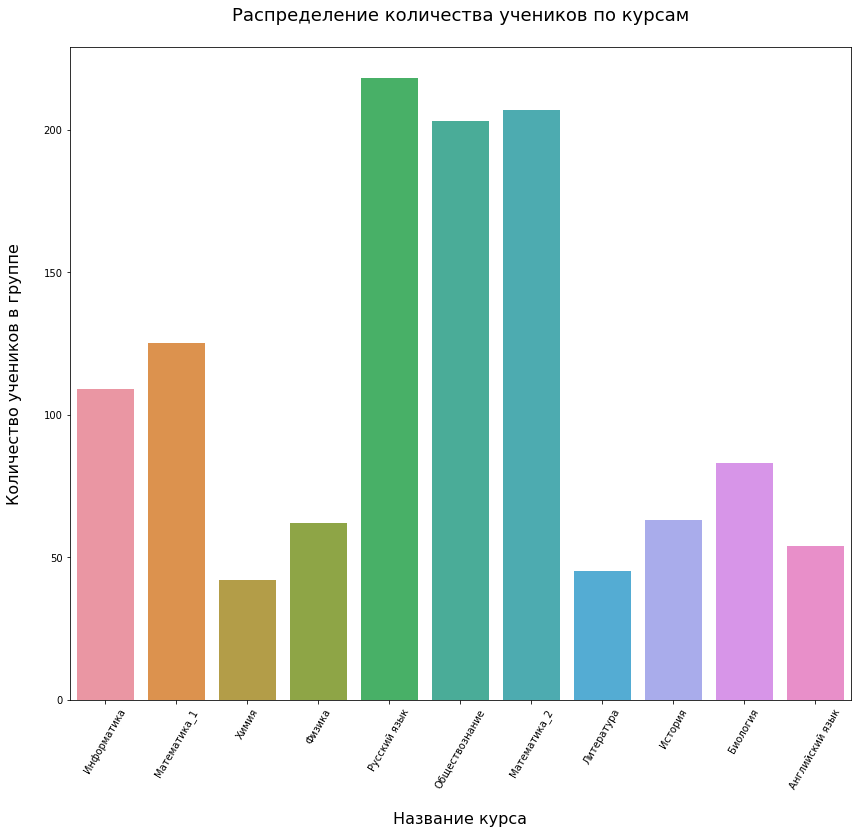

In [32]:
plt.figure(figsize=(14, 12))

sns.barplot(data=courses, x="title", y="size_group")

plt.xlabel('\nНазвание курса', size= 16)
plt.ylabel('Количество учеников в группе\n', size= 16)
plt.title('Распределение количества учеников по курсам\n', size= 18)
plt.xticks(rotation=60)
plt.savefig('courses.png')

Количество правильных тестов

In [33]:
homeworks.head()

,id,title,type,student_id,attempts_count,spent_time,percent,result,created_at,updated_at
0,129563,Задание 1,type6,9935451,1,149.0,0,false,2021-09-30 11:07:53,2021-09-30 12:54:35
1,129563,Задание 1,type6,10266835,1,12.0,0,false,2021-10-30 07:36:44,2021-11-07 09:04:31
2,129563,Задание 1,type6,1245466,1,206.0,100,true,2021-10-22 17:56:46,2021-10-23 18:19:10
3,129563,Задание 1,type6,10207647,1,748.0,100,true,2021-10-18 11:38:22,2021-10-18 12:41:51
4,129563,Задание 1,type6,9957566,1,141.0,100,true,2021-12-29 18:11:45,2022-01-09 07:32:12


In [34]:
done_tests = homeworks.query('result == "true"') \
    .groupby('student_id', as_index=False) \
    .agg({'result' : 'count'}) \
    .rename(columns={'student_id' : 'user_id', 'result' : 'count_result'})

Мержим наши метрики

In [35]:
percent_by_user = percent_by_user.merge(done_tests, on='user_id')

In [36]:
percent_by_user = percent_by_user.rename(columns={'percent_mean' : 'metric: mean percent by done homework',
                                'spent_time_mean' : 'metric: mean percent do homework',
                                'attempts_count' : 'metric: mean count attempts',
                                'count_result' : 'metric: count done result'}).round(2)

In [37]:
# metrics_to_excel = percent_by_user.sort_values('user_id')

# metrics_to_excel

### Считаем пользовательские активности

In [38]:
focus_on = users.query('type == "focus_on"') \
    .groupby('user_id', as_index=False) \
    .agg({'type' : 'count'}) \
    .rename(columns={'type' : 'count_focus_on'}) \
    .sort_values('count_focus_on', ascending=False)

In [39]:
microphone_on = users.query('type == "microphone_on"') \
    .groupby('user_id', as_index=False) \
    .agg({'type' : 'count'}) \
    .rename(columns={'type' : 'count_microphone_on'}) \
    .sort_values('count_microphone_on', ascending=False)

In [40]:
visibility_on = users.query('type == "visibility_on"') \
    .groupby('user_id', as_index=False) \
    .agg({'type' : 'count'}) \
    .rename(columns={'type' : 'count_visibility_on'}) \
    .sort_values('count_visibility_on', ascending=False)

In [41]:
notify_on = users.query('type == "notify_on"') \
    .groupby('user_id', as_index=False) \
    .agg({'type' : 'count'}) \
    .rename(columns={'type' : 'count_notify_on'}) \
    .sort_values('count_notify_on', ascending=False)

In [42]:
count_webcam_on = users.query('type == "webcam_on"') \
    .groupby('user_id', as_index = False) \
    .agg({'type' : 'count'}) \
    .rename(columns={'type' : 'count_webcam_on'}) \
    .sort_values('count_webcam_on', ascending=False)

In [43]:
size_group = group_by_user.rename(columns={'user_id' : 'count_size'}) 

users_size = users.merge(size_group, how='left', on='education_group_id')

mean_size_group = users_size[['user_id', 'count_size']].groupby('user_id', as_index=False) \
    .agg({'count_size' : 'mean'})

In [44]:
# Среднее количество времени на уроке

users_diff = dic_df["user_info"]
connections = dic_df["connection"]
lessons = dic_df["lesson"]
meetings = dic_df["meeting"]

connections['conn_duration'] = pd.to_datetime(connections.lefted_at) - pd.to_datetime(connections.joined_at)
connections['conn_id'] = connections.index 
connections[['user_id', 'lesson_id', 'conn_duration']]

meetings['meet_duration'] = pd.to_datetime(meetings.ended_at) - pd.to_datetime(meetings.created_at)
meetings['meet_id'] = meetings.index 

meetings[['lesson_id' ,'meet_duration']]

usr_con_met = users_diff.merge(connections, on='user_id', how='inner').merge(meetings, on='lesson_id', how='inner')

usr_con_met_no_edu_grp = usr_con_met.copy()
usr_con_met_no_edu_grp = usr_con_met_no_edu_grp.drop_duplicates(subset=['user_id', 'lesson_id', 'meet_id', 'conn_id'])

usr_con_met_no_edu_grp.query('user_id == 9721639 & lesson_id == 1410284')[['user_id', 'lesson_id', 'meet_id', 'conn_id']]

,user_id,lesson_id,meet_id,conn_id
0,9721639,1410284,282,6635


In [45]:
usr_con_met_no_edu_grp[['user_id', 'lesson_id', 'meet_id', 'conn_id', 'meet_duration', 'conn_duration']].sort_values(['user_id', 'lesson_id', 'meet_id', 'conn_id'])
usr_con_met_no_edu_grp['conn_part_of_meet'] = usr_con_met_no_edu_grp.conn_duration / usr_con_met_no_edu_grp.meet_duration
usr_con_met_no_edu_grp_grouped = usr_con_met_no_edu_grp.groupby(['user_id', 'lesson_id', 'meet_id']).sum()
usr_con_met_no_edu_grp_grouped = usr_con_met_no_edu_grp_grouped.reset_index().groupby('user_id').mean().reset_index()
usr_con_met_no_edu_grp_grouped = usr_con_met_no_edu_grp_grouped.drop(usr_con_met_no_edu_grp_grouped[usr_con_met_no_edu_grp_grouped.conn_part_of_meet > 1].index)
usr_con_met_no_edu_grp_grouped[['user_id', 'conn_part_of_meet']]
usr_con_met_no_edu_grp_grouped['conn_part_of_meet'].describe()

count    430.000000
mean       0.716421
std        0.201192
min        0.006659
25%        0.670956
50%        0.780790
75%        0.841429
max        0.976918
Name: conn_part_of_meet, dtype: float64

In [46]:
usr_con_met_no_edu_grp_grouped['conn_part_of_meet'] = (usr_con_met_no_edu_grp_grouped['conn_part_of_meet'] * 100).round(2)

In [47]:
percent_on_stream = usr_con_met_no_edu_grp_grouped[['user_id', 'conn_part_of_meet']].rename(columns={'conn_part_of_meet' : 'mean_percent_time_on_lesson'})

### Сопоставляем с метриками

In [48]:
merge1 = percent_by_user.merge(count_webcam_on, how='left', on='user_id')

In [49]:
merge2 = merge1.merge(notify_on, how='left', on='user_id')

In [50]:
merge3 = merge2.merge(visibility_on, how='left', on='user_id')

In [51]:
merge4 = merge3.merge(microphone_on, how='left', on='user_id')

In [52]:
merge5 = merge4.merge(focus_on, how='left', on='user_id')

In [53]:
merge6 = merge5.merge(mean_size_group, how='left', on='user_id')

In [54]:
merge7 = merge6.merge(percent_on_stream, how='left', on='user_id')

In [55]:
merge7 = merge7.fillna(0)

In [56]:
merge7 = merge7.drop(['user_id'], axis=1)

In [57]:
merge7

,metric: mean percent by done homework,metric: mean percent do homework,metric: mean count attempts,metric: count done result,count_webcam_on,count_notify_on,count_visibility_on,count_microphone_on,count_focus_on,count_size,mean_percent_time_on_lesson
0,78.85,161.30,1.57,44,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,100.00,167.67,1.08,12,0.0,1.0,0.0,0.0,1.0,109.0,2.62
2,90.00,134.67,1.23,27,0.0,0.0,42.0,0.0,44.0,140.5,53.46
3,95.45,10.82,1.23,21,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,83.33,71.00,1.43,50,0.0,27.0,24.0,0.0,38.0,207.0,88.10
...,...,...,...,...,...,...,...,...,...,...,...
570,58.33,85.25,2.17,7,0.0,0.0,0.0,0.0,0.0,0.0,0.00
571,15.00,73.80,2.67,2,0.0,0.0,0.0,0.0,0.0,0.0,0.00
572,83.87,16.35,1.77,26,0.0,0.0,21.0,0.0,36.0,42.0,70.01
573,59.32,31.18,1.89,30,0.0,0.0,0.0,0.0,4.0,203.0,73.91


In [58]:
normal_test = []
for i in merge7.columns:
    shap = shapiro(merge7[i])
    if shap.pvalue < 0.05:
        normal_test.append(shap)
    else:
        continue

In [59]:
normal_test

[ShapiroResult(statistic=0.9225860834121704, pvalue=1.308009982369364e-16),
 ShapiroResult(statistic=0.7921363115310669, pvalue=1.8649171000466304e-26),
 ShapiroResult(statistic=0.964789092540741, pvalue=1.647572356322513e-10),
 ShapiroResult(statistic=0.6418571472167969, pvalue=6.285056787843803e-33),
 ShapiroResult(statistic=0.11180669069290161, pvalue=2.802596928649634e-45),
 ShapiroResult(statistic=0.26585978269577026, pvalue=1.3074114672150543e-42),
 ShapiroResult(statistic=0.2749726176261902, pvalue=1.975830834697992e-42),
 ShapiroResult(statistic=0.12295520305633545, pvalue=2.802596928649634e-45),
 ShapiroResult(statistic=0.25423121452331543, pvalue=7.763193492359487e-43),
 ShapiroResult(statistic=0.8530418872833252, pvalue=1.0150078892151712e-22),
 ShapiroResult(statistic=0.7714766263961792, pvalue=1.5741612474573377e-27)]

### Логарифмируем

In [60]:
merge_log = merge7.copy()

In [61]:
merge_log \
    .loc[:, ['metric: mean percent by done homework', 'metric: mean percent do homework', 'metric: mean count attempts',
            'metric: count done result', 'count_webcam_on', 
            'count_notify_on', 'count_visibility_on',
            'count_microphone_on', 'count_focus_on', 'count_size', 'mean_percent_time_on_lesson']] += 1

In [62]:
merge_log['metric: mean percent by done homework'] = np.log(merge_log['metric: mean percent by done homework'])

In [63]:
merge_log['metric: mean percent do homework'] = np.log(merge_log['metric: mean percent do homework'])

In [64]:
merge_log['metric: mean count attempts'] = np.log(merge_log['metric: mean count attempts'])

In [65]:
merge_log['metric: count done result'] = np.log(merge_log['metric: count done result'])

In [66]:
merge_log['count_webcam_on'] = np.log(merge_log.count_webcam_on)

In [67]:
merge_log['count_notify_on'] = np.log(merge_log.count_notify_on)

In [68]:
merge_log['count_visibility_on'] = np.log(merge_log.count_visibility_on)

In [69]:
merge_log['count_microphone_on'] = np.log(merge_log.count_microphone_on)

In [70]:
merge_log['count_focus_on'] = np.log(merge_log.count_focus_on)

In [71]:
merge_log['count_size'] = np.log(merge_log.count_size)

In [72]:
merge_log['mean_percent_time_on_lesson'] = np.log(merge_log.mean_percent_time_on_lesson)

Корреляция

In [73]:
corr = merge_log.corr(method='spearman')

In [74]:
corr

,metric: mean percent by done homework,metric: mean percent do homework,metric: mean count attempts,metric: count done result,count_webcam_on,count_notify_on,count_visibility_on,count_microphone_on,count_focus_on,count_size,mean_percent_time_on_lesson
metric: mean percent by done homework,1.000000,0.188530,-0.524311,0.316544,0.017005,0.048081,0.018821,-0.092578,0.063177,0.018596,-0.038749
metric: mean percent do homework,0.188530,1.000000,-0.332454,0.043965,-0.010290,0.066486,0.053644,-0.040322,0.120699,0.016643,0.069799
metric: mean count attempts,-0.524311,-0.332454,1.000000,-0.049995,0.091924,0.020799,0.061163,0.160860,-0.008063,0.024354,0.059778
metric: count done result,0.316544,0.043965,-0.049995,1.000000,0.230946,0.257696,0.385288,0.065778,0.347452,0.190663,0.224752
count_webcam_on,0.017005,-0.010290,0.091924,0.230946,1.000000,0.282627,0.319315,0.131198,0.309957,0.238372,0.312950
count_notify_on,0.048081,0.066486,0.020799,0.257696,0.282627,1.000000,0.480366,0.071181,0.603886,0.404346,0.444618
count_visibility_on,0.018821,0.053644,0.061163,0.385288,0.319315,0.480366,1.000000,0.236425,0.815841,0.646678,0.643855
count_microphone_on,-0.092578,-0.040322,0.160860,0.065778,0.131198,0.071181,0.236425,1.000000,0.010665,0.067963,0.107317
count_focus_on,0.063177,0.120699,-0.008063,0.347452,0.309957,0.603886,0.815841,0.010665,1.000000,0.653523,0.663887
count_size,0.018596,0.016643,0.024354,0.190663,0.238372,0.404346,0.646678,0.067963,0.653523,1.000000,0.669558


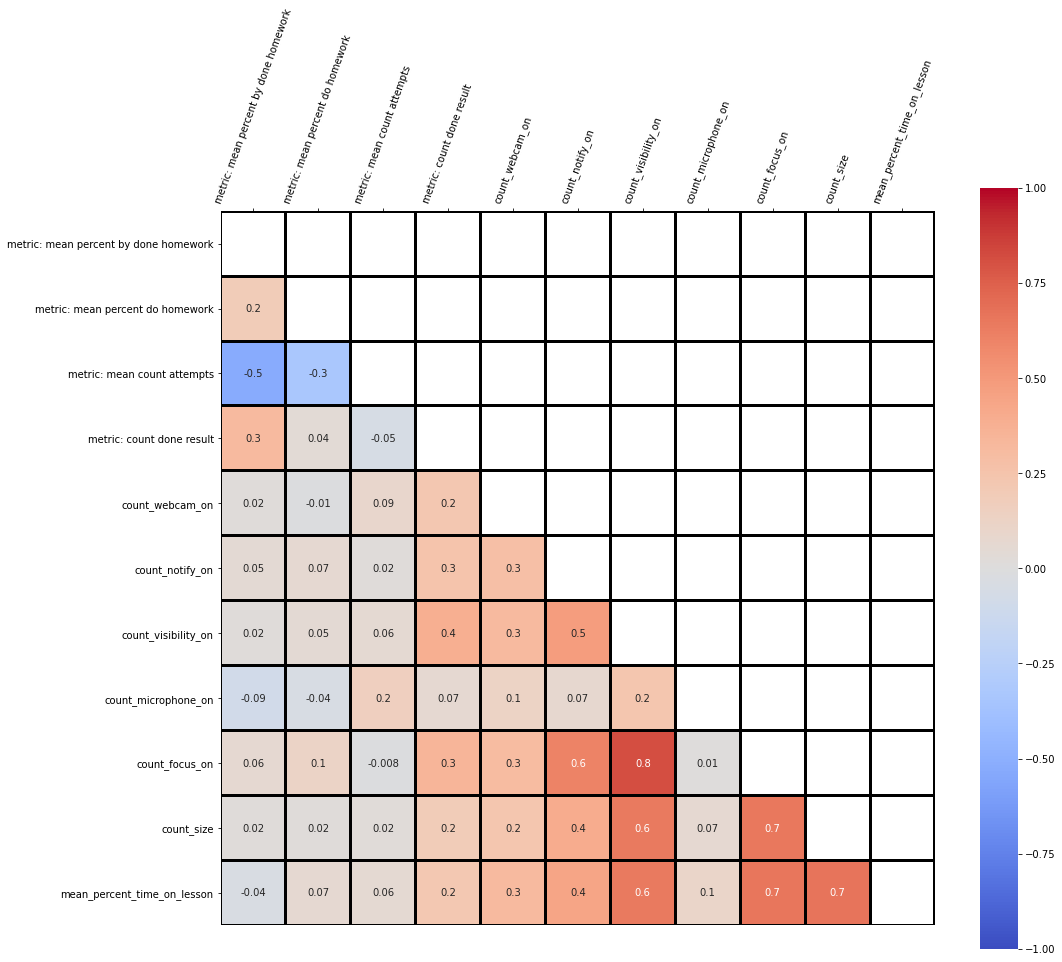

In [75]:
plt.figure(figsize=(16, 14))

ax = sns.heatmap(corr, 
            cmap='coolwarm',
            annot=True,
            linewidths=2,
            linecolor='black',
            square=True,
            mask=np.triu(corr),
            fmt='.1g',
            vmin=-1,
            vmax=1)

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
sns.set(font_scale=1)

plt.xticks(rotation=70)
plt.savefig('heatmap.png')

In [76]:
def t_statistic(xs, ys):
    '''Вычисление t-статистики'''
    r = xs.corr(ys)  # как вариант, correlation(xs, ys)
    df = xs.count() - 2
    return r * np.sqrt(df / 1 - r ** 2)

def ex_3_9():
    '''Выполнение двухстороннего t-теста'''
    df = merge_log[['metric: mean percent by done homework', 'count_size']]
    xs = merge_log['metric: mean percent by done homework']
    ys = merge_log['count_size']
    t_value = t_statistic(xs, ys)
    df = xs.count() - 2 
    p = 2 * t.sf(t_value, df)  # функция выживания 
    return {'t-значение':t_value, 'p-значение':p}

In [77]:
ex_3_9()

{'t-значение': 1.9529693937572274, 'p-значение': 0.05130962147625032}